Descriptive Statistics:
                age   sex          bmi     children smoker     region  \
count   1338.000000  1338  1338.000000  1338.000000   1338       1338   
unique          NaN     2          NaN          NaN      2          4   
top             NaN  male          NaN          NaN     no  southeast   
freq            NaN   676          NaN          NaN   1064        364   
mean      39.207025   NaN    30.663397     1.094918    NaN        NaN   
std       14.049960   NaN     6.098187     1.205493    NaN        NaN   
min       18.000000   NaN    15.960000     0.000000    NaN        NaN   
25%       27.000000   NaN    26.296250     0.000000    NaN        NaN   
50%       39.000000   NaN    30.400000     1.000000    NaN        NaN   
75%       51.000000   NaN    34.693750     2.000000    NaN        NaN   
max       64.000000   NaN    53.130000     5.000000    NaN        NaN   

             charges  
count    1338.000000  
unique           NaN  
top              NaN  
freq   

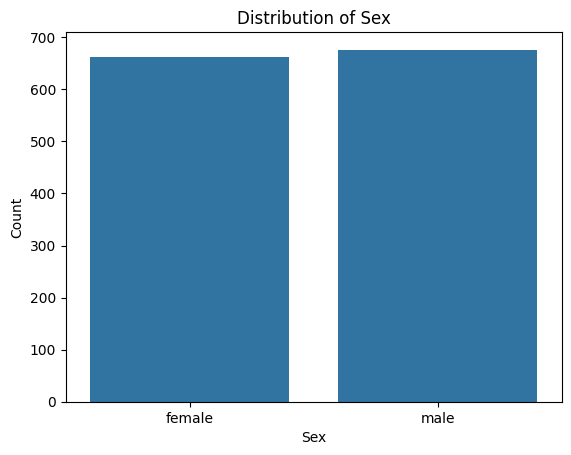

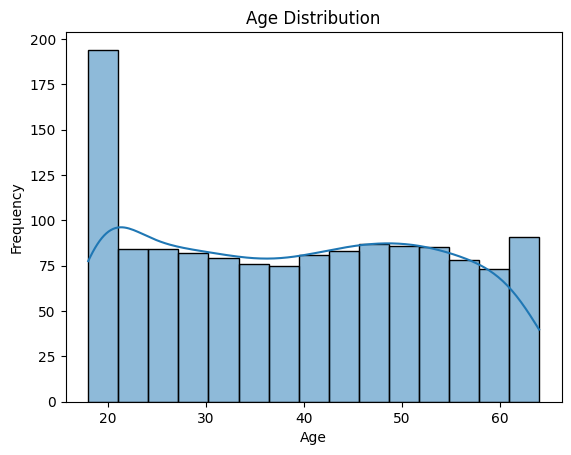

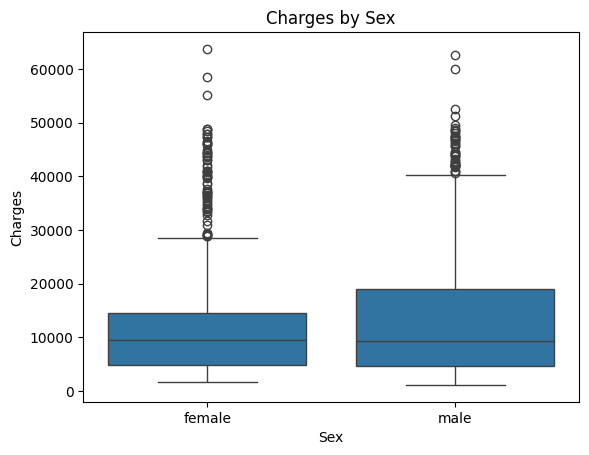

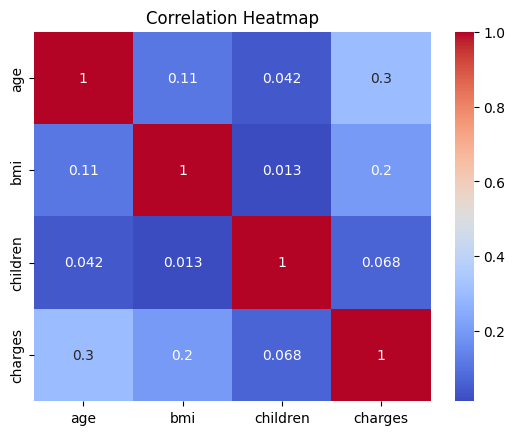

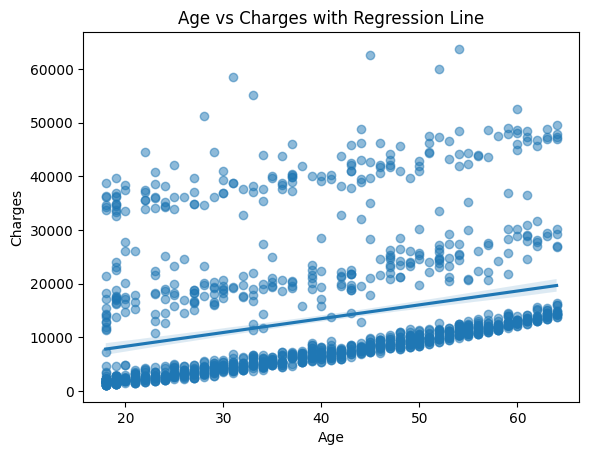


Model Performance (Test Set):
                       RMSE      MAE    R2
Linear Regression   7814.06  3888.44  0.61
Ridge               7753.86  3877.07  0.61
Lasso              13053.72  8603.16 -0.10
ElasticNet         13053.72  8603.16 -0.10

Top coefficients by model:
                 Feature  Coefficient              Model
4        cat__smoker_yes     1.551519  Linear Regression
0               num__age     0.481643  Linear Regression
2          num__children     0.112328  Linear Regression
1               num__bmi     0.082146  Linear Regression
5  cat__region_northeast     0.078739  Linear Regression
4        cat__smoker_yes     1.542506              Ridge
0               num__age     0.481025              Ridge
2          num__children     0.112314              Ridge
1               num__bmi     0.082031              Ridge
5  cat__region_northeast     0.078472              Ridge
0               num__age     0.000000              Lasso
1               num__bmi     0.000000     

In [2]:
# Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import TransformedTargetRegressor

# Load dataset
df = pd.read_csv("insurance.csv")

# Descriptive statistics
print("Descriptive Statistics:")
print(df.describe(include='all'))

# 5 Required Figures

# 1) Distribution of Sex
sns.countplot(data=df, x='sex')
plt.title("Distribution of Sex")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.show()

# 2) Age Distribution
sns.histplot(df['age'], bins=15, kde=True)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

# 3) Charges by Sex
sns.boxplot(data=df, x='sex', y='charges')
plt.title("Charges by Sex")
plt.xlabel("Sex")
plt.ylabel("Charges")
plt.show()

# 4) Correlation Heatmap (numeric vars)
corr = df[['age','bmi','children','charges']].corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# 5) Age vs Charges with Regression Line
sns.regplot(data=df, x='age', y='charges', scatter_kws={'alpha':0.5})
plt.title("Age vs Charges with Regression Line")
plt.xlabel("Age")
plt.ylabel("Charges")
plt.show()

# Preprocessing and Model Training
X = df[['age','sex','bmi','children','smoker','region']]
y = df['charges']

num = ['age','bmi','children']
cat = ['sex','smoker','region']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num),
        ('cat', OneHotEncoder(drop='if_binary', handle_unknown='ignore'), cat)
    ]
)

# Helper for evaluation
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)          
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Train/test split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define models
lin_reg = TransformedTargetRegressor(
    regressor=Pipeline([('pre', preprocessor), ('model', LinearRegression())]),
    func=np.log1p, inverse_func=np.expm1
)

ridge = TransformedTargetRegressor(
    regressor=Pipeline([('pre', preprocessor), ('model', Ridge())]),
    func=np.log1p, inverse_func=np.expm1
)

lasso = TransformedTargetRegressor(
    regressor=Pipeline([('pre', preprocessor), ('model', Lasso(max_iter=20000))]),
    func=np.log1p, inverse_func=np.expm1
)

enet = TransformedTargetRegressor(
    regressor=Pipeline([('pre', preprocessor), ('model', ElasticNet(max_iter=20000))]),
    func=np.log1p, inverse_func=np.expm1
)

# Evaluate all models 
results = {}
results['Linear Regression'] = evaluate_model(lin_reg, X_train, X_test, y_train, y_test)
results['Ridge'] = evaluate_model(ridge, X_train, X_test, y_train, y_test)
results['Lasso'] = evaluate_model(lasso, X_train, X_test, y_train, y_test)
results['ElasticNet'] = evaluate_model(enet, X_train, X_test, y_train, y_test)

# Results table
results_df = pd.DataFrame(results).T
print("\nModel Performance (Test Set):")
print(results_df.round(2))

# Coefficient Extraction for Linear, Ridge, Lasso, ElasticNet 

def get_coefficients(model, model_name):
    """
    Extract coefficients from a trained TransformedTargetRegressor
    that contains a Pipeline with preprocessing + linear model.
    """
    # linear model
    linear_model = model.regressor_.named_steps['model']
    
    # Feature names after preprocessing
    feature_names = model.regressor_.named_steps['pre'].get_feature_names_out()
    
    # Coefficients
    coefs = linear_model.coef_
    
    # Put into DataFrame
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefs,
        'Model': model_name
    }).sort_values(by='Coefficient', key=abs, ascending=False)
    
    return coef_df

# Collect coefficients for all models
coef_lin = get_coefficients(lin_reg, "Linear Regression")
coef_ridge = get_coefficients(ridge, "Ridge")
coef_lasso = get_coefficients(lasso, "Lasso")
coef_enet = get_coefficients(enet, "ElasticNet")

# Combine into one table
all_coefs = pd.concat([coef_lin, coef_ridge, coef_lasso, coef_enet])

print("\nTop coefficients by model:")
print(all_coefs.groupby("Model").head(5))  # print top 5 per model


